# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [2]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [3]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [4]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables utiles para visualizaciones

In [5]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   year         48532 non-null  int32         
 10  month        48532 non-null  int32         
 11  dayofweek    48532 non-null  int32         
 12  is_weekend   48532 non-null  int64         
 13  goal_diff    48532 non-null  int64         
 14  total_score  48532 non-null  int64         
 15  result       48532 non-null  object        
dtypes: b

In [7]:
results.describe()

,date,home_score,away_score,year,month,dayofweek,is_weekend,goal_diff,total_score
count,48532,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000
mean,1993-10-17 04:11:45.579823488,1.758180,1.181550,1993.265557,6.883664,3.457018,0.395945,1.716208,2.939730
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1980-02-27 00:00:00,1.000000,0.000000,1980.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,2000-03-15 00:00:00,1.000000,1.000000,2000.000000,7.000000,3.000000,0.000000,1.000000,3.000000
75%,2012-11-07 06:00:00,2.000000,2.000000,2012.000000,10.000000,5.000000,1.000000,2.000000,4.000000
max,2025-09-09 00:00:00,31.000000,21.000000,2025.000000,12.000000,6.000000,1.000000,31.000000,31.000000
std,NaN,1.773101,1.400946,25.301688,3.228533,1.981937,0.489058,1.791796,2.095142


#### Visualizaciones de variables numéricas

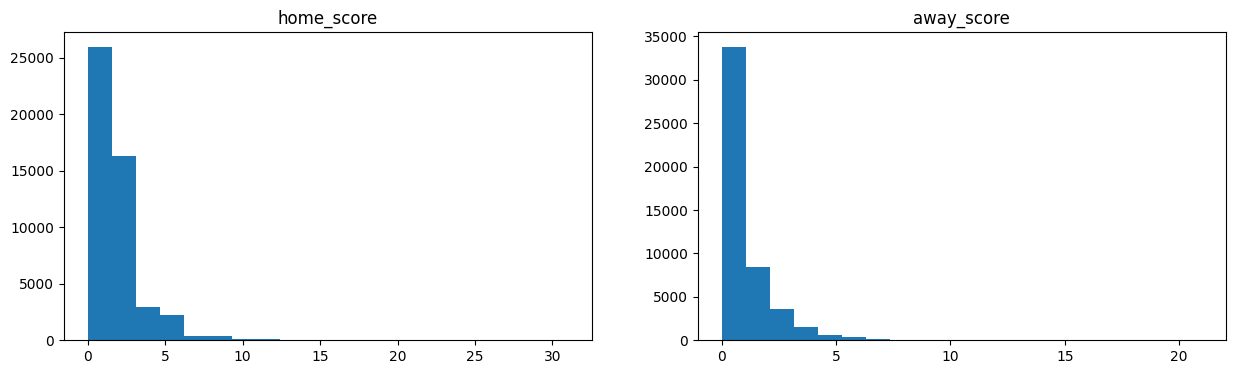

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

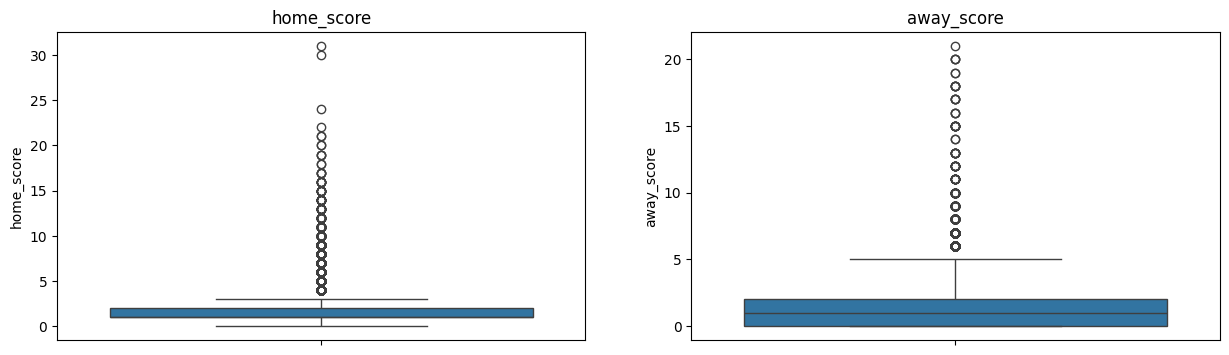

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

📝 Si bien existen outliers, estos no pueden tratarse como errores ya que son resultados reales de partidos de fútbol.

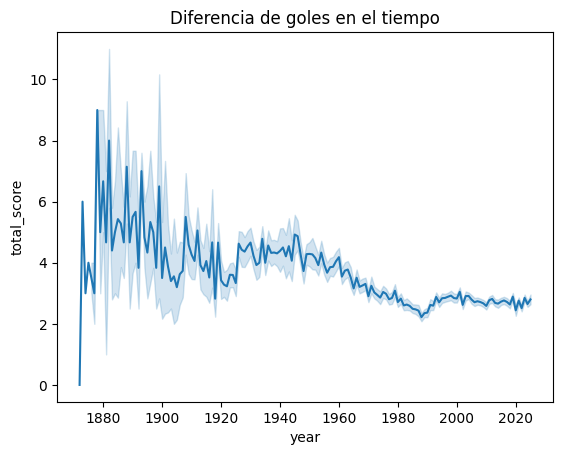

In [10]:
sns.lineplot(data=results, x="year", y="total_score")
plt.title("Diferencia de goles en el tiempo")
plt.show()

📝 Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

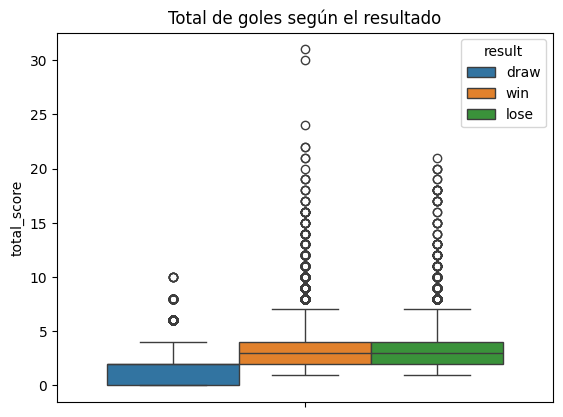

In [11]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

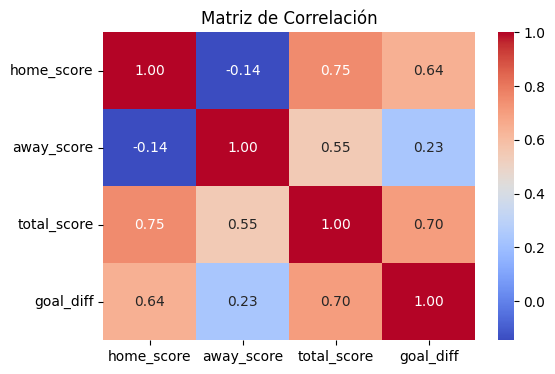

In [12]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#### Visualización de variables categoricas

In [13]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')


In [14]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48532,48532,48532,48532,48532,48532
unique,325,318,188,2115,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,578,18116,736,1458,23797


Veamos la distribución del target

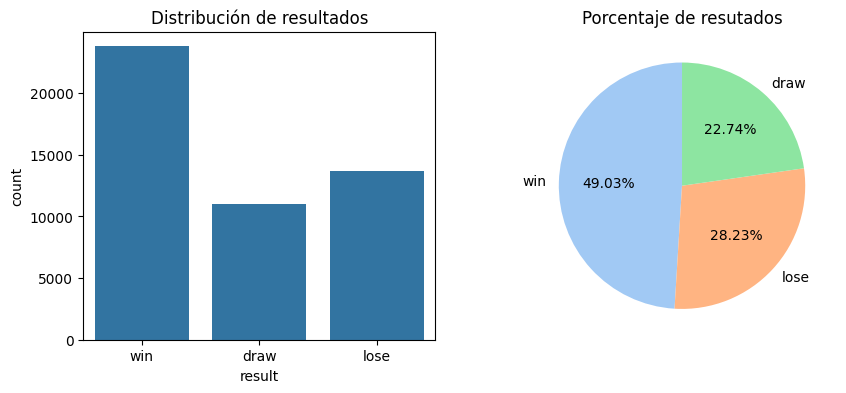

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

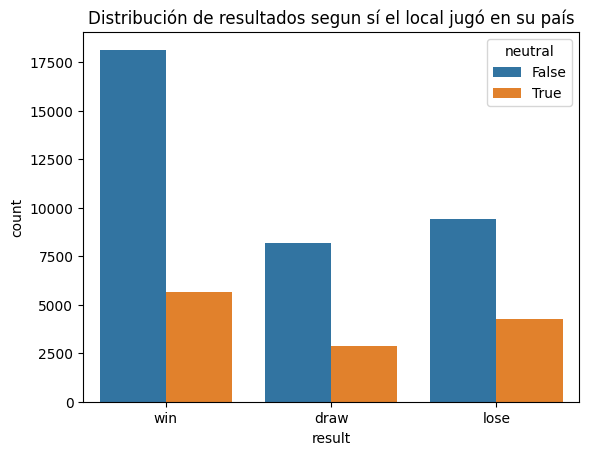

In [16]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

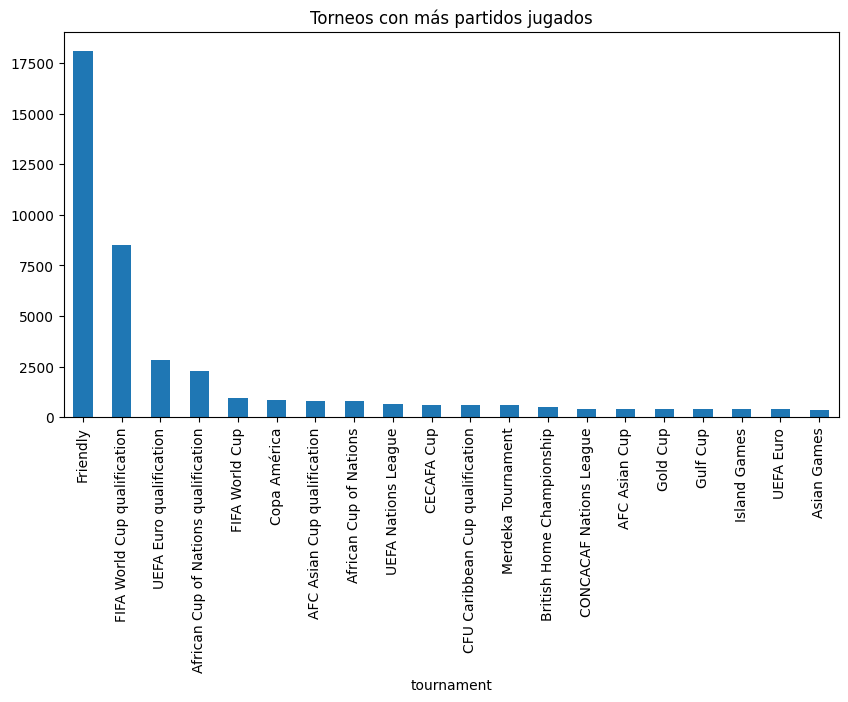

In [17]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

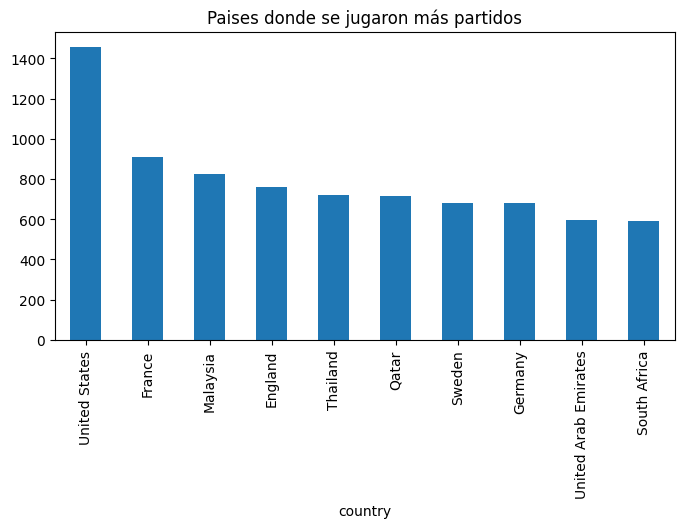

In [18]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

📝 De los torneos, se destaca el tipo "amistoso" pero también aparecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial. La cardinalidad de los torneos puede influir al momento de evaluar los modelos.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

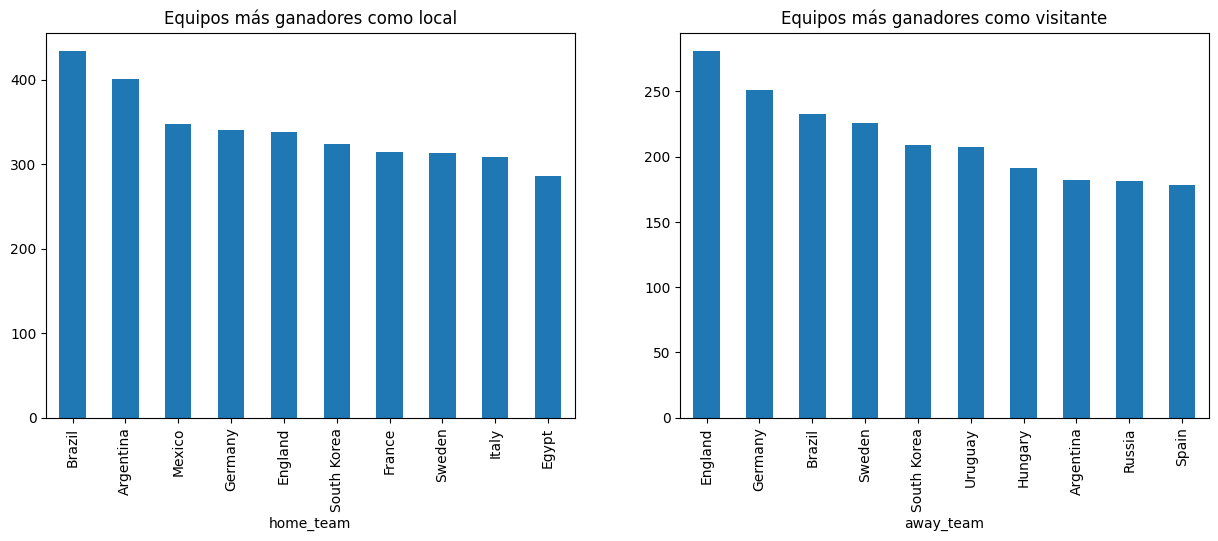

In [19]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 En base al analisis previo, se decide filtrar los datos a partir de 1920. Antes de esa fecha, había más diferencia entre los equipos (mayor diferencia de goles).

Otros filtros a considerar que pueden introducir ruido en el modelo:
* Cardinalidad de los torneos: existen demasiados torneos por lo cual podría ser conveniente centrarse en los mas conocidos.

In [20]:
results_filtered = results[results["year"] >= 1920].reset_index(drop=True)

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

Original (48532, 16)
Filtrado (47938, 16)


📝 Como el objetivo es predecir el resultado del partido, no podemos usar los registros como tal ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [21]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local
results_filtered["home_n_winrate"] = (
    results_filtered.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante
results_filtered['away_n_winrate'] = (
    results_filtered.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)


# Promedio de goles a favor
results_filtered['home_n_avg_gf'] = (
    results_filtered.groupby('home_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_gf'] = (
    results_filtered.groupby('away_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Promedio de goles en contra
results_filtered['home_n_avg_ga'] = (
    results_filtered.groupby('home_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_ga'] = (
    results_filtered.groupby('away_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

/tmp/ipykernel_2086583/2586177956.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby("home_team")["result"]
/tmp/ipykernel_2086583/2586177956.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby('away_team')['result']
/tmp/ipykernel_2086583/2586177956.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby('home_team')['home_score']
/tmp/ipykernel_2

In [22]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Nulos en base al procesamiento:
 home_n_avg_gf    325
away_n_avg_gf    318
home_n_avg_ga    325
away_n_avg_ga    318
dtype: int64


Como aparecen valores nulos, se decide imputar estos valores con 1.

In [23]:
features_nulls = [
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)

Codificamos las variables categoricas:
- result se codifica con LabelEncoder por ser la variable a predecir
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta

In [24]:
result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])
print("Clases del resultado: ", result_encoder.classes_)

tournament_encoder = TargetEncoder()
results_filtered["tournament_enc"] = tournament_encoder.fit_transform(results_filtered["tournament"], results_filtered["result_enc"])

home_team_encoder = TargetEncoder()
results_filtered["home_team_enc"] = home_team_encoder.fit_transform(results_filtered["home_team"], results_filtered["result_enc"])

away_team_encoder = TargetEncoder()
results_filtered["away_team_enc"] = away_team_encoder.fit_transform(results_filtered["away_team"], results_filtered["result_enc"])

results_filtered["neutral"] = results_filtered["neutral"].astype(int)

Clases del resultado:  ['draw' 'lose' 'win']


📝 Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una **serie temporal**. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada.

In [42]:
train = results_filtered[results_filtered["date"] < "2015-01-01"]
test = results_filtered[results_filtered["date"] >= "2015-01-01"]
print(f"Train size: {(len(train)/len(results_filtered))*100:.2f} %")
print(f"Test size: {(len(test)/len(results_filtered))*100:.2f} %")

Train size: 78.81 %
Test size: 21.19 %


In [26]:
# Definimos las features que usaremos para el modelo:
features = [
    'home_n_winrate', 'away_n_winrate',
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
    'neutral', 'tournament_enc',
    'home_team_enc', 'away_team_enc',
    'month', 'is_weekend'
]

target = "result_enc"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

Finalmente, se estandarizan las variables para que todas tengan la misma escala.

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.

In [28]:
# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

#print_classification_results(y_test, y_pred, "Regresión Logística")

In [29]:
# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

#print_classification_results(y_test, y_pred, "KNN")

In [30]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovr', probability=True)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

#print_classification_results(y_test, y_pred, "SVC")

In [31]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

#print_classification_results(y_test, y_pred, "Árbol de Decisión")

In [32]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

#print_classification_results(y_test, y_pred, "Random Forest")

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

📝 En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar en la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global y log loss.

In [40]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    target_names = result_encoder.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()


Resultados para Regresión Logística:

Accuracy: 0.5259426996160284
F1-score (macro): 0.49412382041355013

Classification Report:
               precision    recall  f1-score   support

        draw       0.29      0.34      0.32      2341
        lose       0.51      0.54      0.52      2963
         win       0.68      0.61      0.64      4853

    accuracy                           0.53     10157
   macro avg       0.50      0.50      0.49     10157
weighted avg       0.54      0.53      0.53     10157



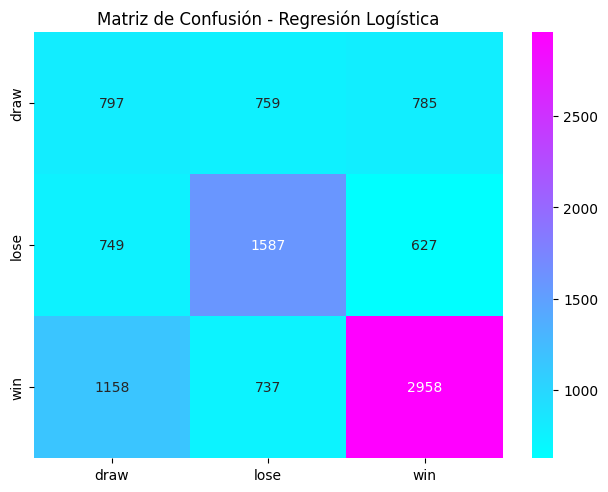


Resultados para KNN:

Accuracy: 0.5370680318991828
F1-score (macro): 0.4387295044151827

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.11      0.16      2341
        lose       0.50      0.46      0.48      2963
         win       0.59      0.79      0.68      4853

    accuracy                           0.54     10157
   macro avg       0.45      0.45      0.44     10157
weighted avg       0.49      0.54      0.50     10157



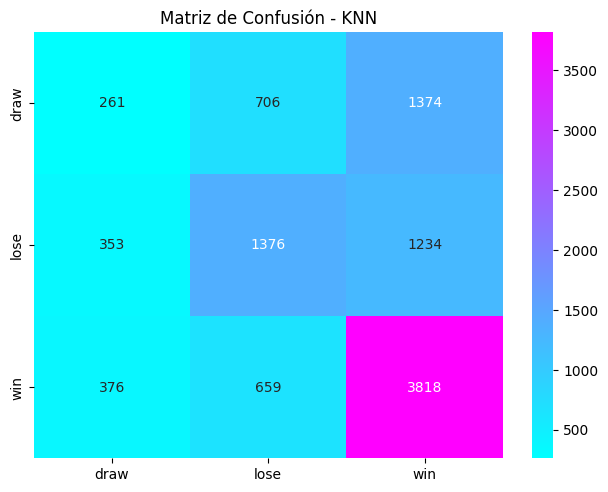


Resultados para SVC:

Accuracy: 0.560893964753372
F1-score (macro): 0.4096170928126585

Classification Report:
               precision    recall  f1-score   support

        draw       0.34      0.02      0.03      2341
        lose       0.54      0.47      0.50      2963
         win       0.57      0.88      0.69      4853

    accuracy                           0.56     10157
   macro avg       0.48      0.46      0.41     10157
weighted avg       0.51      0.56      0.49     10157



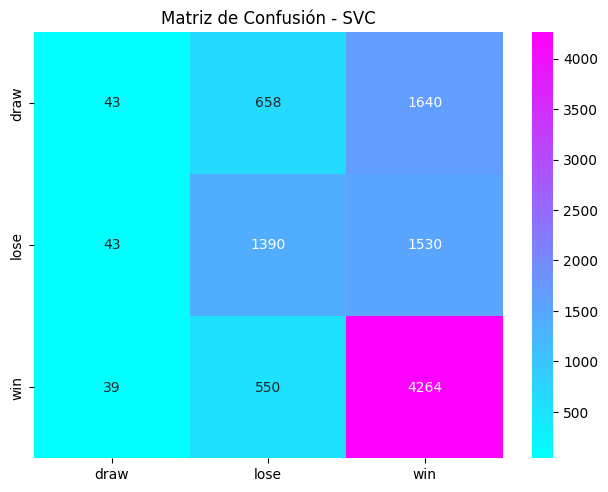


Resultados para Árbol de Decisión:

Accuracy: 0.48065373633947034
F1-score (macro): 0.4616502428122386

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.41      0.33      2341
        lose       0.47      0.45      0.46      2963
         win       0.67      0.53      0.59      4853

    accuracy                           0.48     10157
   macro avg       0.47      0.46      0.46     10157
weighted avg       0.52      0.48      0.49     10157



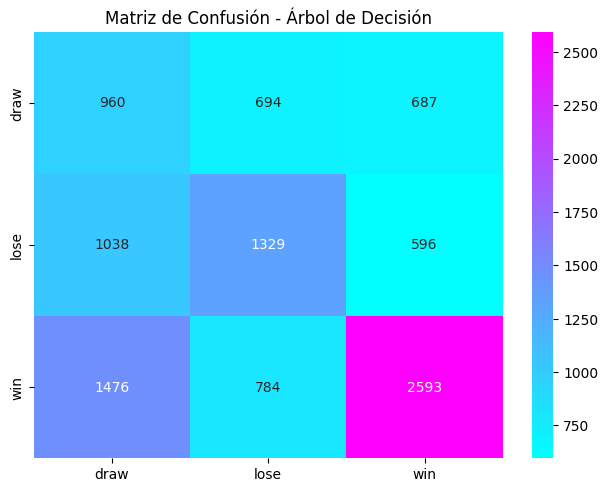


Resultados para Random Forest:

Accuracy: 0.5377572117751305
F1-score (macro): 0.4843780862951039

Classification Report:
               precision    recall  f1-score   support

        draw       0.30      0.25      0.27      2341
        lose       0.51      0.52      0.51      2963
         win       0.65      0.69      0.67      4853

    accuracy                           0.54     10157
   macro avg       0.48      0.49      0.48     10157
weighted avg       0.53      0.54      0.53     10157



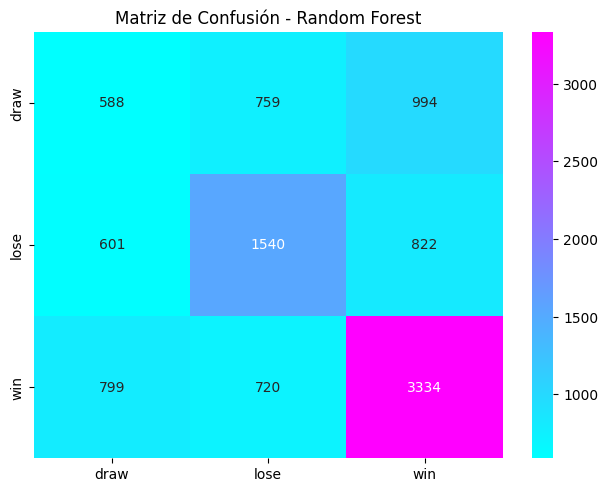

In [41]:
print_classification_results(y_test, y_pred_logreg, "Regresión Logística")

print_classification_results(y_test, y_pred_knn, "KNN")

print_classification_results(y_test, y_pred_svc, "SVC")

print_classification_results(y_test, y_pred_dtc, "Árbol de Decisión")

print_classification_results(y_test, y_pred_rfc, "Random Forest")

---

📝 No se obtuvieron resultados muy favorables. Algunas cosas a analizar:
- La cantidad de observaciones puede ser insuficiente para entrenar los modelos.
- Alta cardinalidad de los tipos de torneos. Utilizar los mas conocidos o agrupar los menos conocidos en una sola categoria.
- Target con desbalance de clases. Podria ser mas conveniente utilizar un objetivo binario (win/lose).